In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
g4_tool = "regex"

SPECIES_DATA = "../results/species_data.csv"
G4_PATH = f"../results/{g4_tool}_g4_distribution.csv"
VIRUS_DATA_PATH = "../metadata/virus_data.tsv"    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'   
    
def get_host_domain(host):
    host_domain = {
        "vertebrates": "Eukaryota",
        "invertebrates": "Eukaryota",
        "algae": "Eukaryota",
        "plants": "Eukaryota",
        "protozoa": "Eukaryota",
        "bacteria": "Bacteria",
        "land plants": "Eukaryota",
        "human": "Eukaryota",
        "eukaryotic algae": "Eukaryota",
        "archaea": "Archaea",
        "diatom": "Eukaryota",
        "fungi": "Eukaryota",
        "-" : "-"
    }
    hosts = host.split(",")
    domains = [host_domain[host] for host in hosts]
    unique_domains = list(set(domains))
    return ", ".join(unique_domains)

In [3]:
# species data
df_species = pd.read_csv(SPECIES_DATA)
df_species = df_species[["Accession", "Species", "Genome Size", "GC Percentage", "Taxa", "Kingdom", "Phylum"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)

# g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)

# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4["GC Corrected G4 Density (per Mb)"] = df_g4["G4 Density (per Mb)"] / (df_g4["GC Percentage"] / 50)

# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

# for viruses, set kingdom as virus
df_g4.loc[df_g4["Taxa"] == "viral", "Kingdom"] = "Virus"

df_g4.head()

,Accession,g4_count,total_g4_length,Species,Genome Size,GC Percentage,Taxa,Kingdom,Phylum,Domain,G4 Density (per Mb),GC Corrected G4 Density (per Mb)
0,GCA_000002515.1,36.0,890.0,Kluyveromyces lactis,10689156.0,38.5,fungi,Fungi,Ascomycota,Eukaryota,3.367899,4.373895
1,GCA_000002765.3,837.0,20268.0,Plasmodium falciparum 3D7,23292622.0,19.0,protozoa,Protista,Apicomplexa,Eukaryota,35.934125,94.563488
2,GCA_000002985.3,2372.0,54608.0,Caenorhabditis elegans,100272607.0,35.0,invertebrate,Animalia,Nematoda,Eukaryota,23.655513,33.793591
3,GCA_000006605.1,154.0,4017.0,Corynebacterium jeikeium K411,2476822.0,61.0,bacteria,Eubacteria,Actinomycetota,Bacteria,62.176450,50.964304
4,GCA_000006645.1,66.0,1652.0,Yersinia pestis KIM10+,4701745.0,47.5,bacteria,Eubacteria,Pseudomonadota,Bacteria,14.037341,14.776149


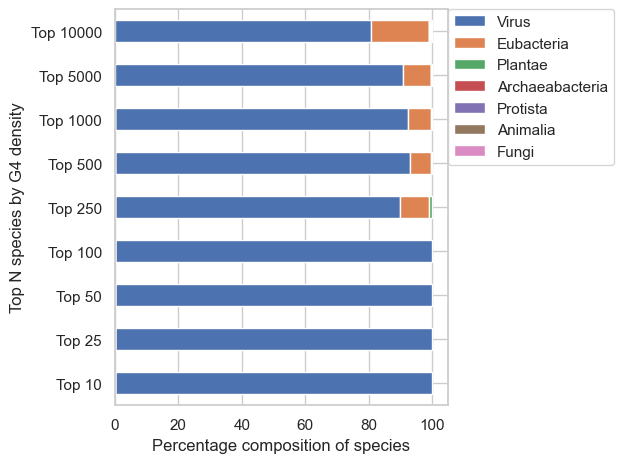

In [4]:
# get top species by G4 density
df_g4 = df_g4.sort_values(by="G4 Density (per Mb)", ascending=False)

TOP = [10, 25, 50, 100, 250, 500, 1000, 5000, 10000]
composition_data = []

for top in TOP:
    df_g4_top = df_g4.head(top)
    df_g4_grouped = df_g4_top.groupby("Kingdom").agg({
        "Accession": "count",
        }).reset_index()
    df_g4_grouped = df_g4_grouped.rename(columns={"Accession": "No. of species"})
    # sort by No. of species
    df_g4_grouped = df_g4_grouped.sort_values(by="No. of species", ascending=False)
    # convert to percentage
    df_g4_grouped["No. of species"] = df_g4_grouped["No. of species"] / top * 100
    composition = {}
    for index, row in df_g4_grouped.iterrows():
        composition[row["Kingdom"]] = row["No. of species"]
    # create new row object
    row = {"Top": f"Top {top}", "Kingdom composition": composition}
    composition_data.append(row)

df_composition = pd.DataFrame(composition_data)
df_composition = pd.concat([df_composition.drop(['Kingdom composition'], axis=1), df_composition['Kingdom composition'].apply(pd.Series)], axis=1)

# plot horizontal bar plot
sns.set_theme(style="whitegrid")
df_composition = df_composition.set_index("Top")
df_composition.plot(kind="barh", stacked=True, rot=0)
# move legend outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Percentage composition of species")
plt.ylabel("Top N species by G4 density")
plt.tight_layout()


In [5]:
df_virus_data = pd.read_csv(VIRUS_DATA_PATH, sep="\t")
df_virus_host_data = df_virus_data[['#Organism/Name', 'Host']]

# convert df_virus_host_data to dictionary with species as key and host as value
virus_host_dict = df_virus_host_data.set_index('#Organism/Name').T.to_dict('list')
virus_host_dict = {k: [x.strip() for x in list(set(','.join(set(v)).split(',')))] for k, v in virus_host_dict.items()}
# convert to comma separated string
virus_host_dict = {k: ','.join(v) for k, v in virus_host_dict.items()}

# get host info for all viral species 
df_g4_virus = df_g4[df_g4["Kingdom"] == "Virus"]
df_g4_virus["Host"] = df_g4_virus["Species"].map(virus_host_dict)
df_g4_virus = df_g4_virus.dropna()
df_g4_virus["Host Domain"] = df_g4_virus["Host"].apply(get_host_domain)

# get list of of hosts
hosts = df_g4_virus["Host"].unique()
hosts = [x.split(',') for x in hosts]
hosts = [item for sublist in hosts for item in sublist]
hosts = list(set(hosts))
print(hosts)

# get top viral phyla with highest G4 densities
df_g4_virus_top = df_g4_virus.head(1000)
df_g4_virus_grouped_top = df_g4_virus_top.groupby("Phylum").agg({
    "Accession": "count",
    "g4_count": "sum",
    "G4 Density (per Mb)": "mean",
    "GC Corrected G4 Density (per Mb)": "mean",
    "Host": lambda x: ', '.join(set(','.join(set(x)).split(',')).difference({'-'})),
    "Host Domain": lambda x: ', '.join(set(','.join(set(x)).split(',')).difference({'-'}))
    }).reset_index()
df_g4_virus_grouped_top.columns = ["Phylum", "No. of species", "Total no. of G4s", "Average G4 Density (per Mb)", "Average GC Corrected G4 Density (per Mb)", "Hosts", "Host Domains"]
df_g4_virus_grouped_top = df_g4_virus_grouped_top.sort_values(by="No. of species", ascending=False)
df_g4_virus_grouped_top.head(100)

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_18066/1229881199.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  virus_host_dict = df_virus_host_data.set_index('#Organism/Name').T.to_dict('list')


['algae', '-', 'vertebrates', 'human', 'diatom', 'protozoa', 'archaea', 'plants', 'bacteria', 'invertebrates', 'fungi', 'eukaryotic algae', 'land plants']


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_18066/1229881199.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g4_virus["Host"] = df_g4_virus["Species"].map(virus_host_dict)


,Phylum,No. of species,Total no. of G4s,Average G4 Density (per Mb),Average GC Corrected G4 Density (per Mb),Hosts,Host Domains
8,Peploviricota,578,104328.0,1140.605721,880.624988,"vertebrates, human",Eukaryota
2,Cressdnaviricota,326,398.0,667.900158,689.695682,"vertebrates, human, invertebrates, fungi, euka...",Eukaryota
10,Pisuviricota,25,161.0,769.467707,698.858980,"vertebrates, human",Eukaryota
6,Kitrinoviricota,24,203.0,1150.704471,960.124052,"fungi, vertebrates, human, land plants",Eukaryota
1,Cossaviricota,13,54.0,669.420447,750.587039,vertebrates,Eukaryota
12,Uroviricota,8,237.0,668.643391,474.415436,bacteria,Bacteria
0,Artverviricota,7,43.0,746.444645,690.462071,"vertebrates, human",Eukaryota
4,Duplornaviricota,7,24.0,677.816370,544.544466,"invertebrates, fungi, vertebrates",Eukaryota
7,Lenarviricota,5,9.0,787.483695,714.191050,,
11,Preplasmiviricota,4,8.0,926.570717,758.536963,vertebrates,Eukaryota


In [6]:
# conduct a t-test to compare G4 densities between viruses with Eukaryotic and non-Eukaryotic hosts
df_g4_virus_eukaryotic = df_g4_virus_top[df_g4_virus["Host Domain"].str.contains("Eukaryota")]
df_g4_virus_non_eukaryotic = df_g4_virus[df_g4_virus["Host Domain"].str.contains("Bacteria|Archaea")]
ttest_ind(df_g4_virus_eukaryotic["G4 Density (per Mb)"], df_g4_virus_non_eukaryotic["G4 Density (per Mb)"])

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_18066/1631803504.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_g4_virus_eukaryotic = df_g4_virus_top[df_g4_virus["Host Domain"].str.contains("Eukaryota")]


TtestResult(statistic=np.float64(209.30205615392052), pvalue=np.float64(0.0), df=np.float64(11499.0))

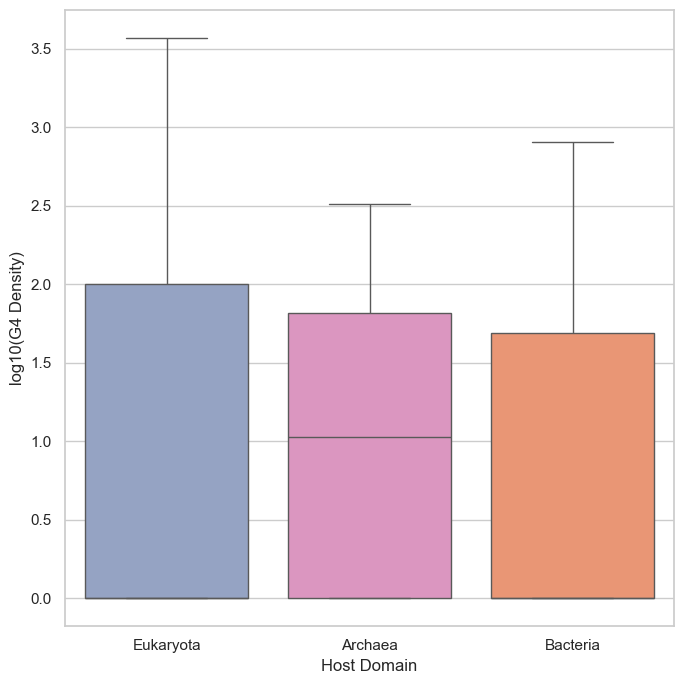

In [7]:
df_g4_virus_host_domain = df_g4_virus.explode("Host Domain")
df_g4_virus_host_domain = df_g4_virus_host_domain[df_g4_virus_host_domain["Host Domain"] != "-"]
df_g4_virus_host_domain["log10(G4 Density)"] = np.log10(df_g4_virus_host_domain["G4 Density (per Mb)"]+1)

# draw a boxplot to compare G4 densities between viruses with different host domains
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 7))
sns.boxplot(
    x="Host Domain", 
    y="log10(G4 Density)", 
    data=df_g4_virus_host_domain,
    hue="Host Domain",
    palette=color_map,
    order=["Eukaryota", "Archaea", "Bacteria"]
)
plt.tight_layout()